In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import os
from tqdm import tqdm

df = pd.read_csv("../../data/data/train-metadata.csv", low_memory=False)

class_0 = df[df['target'] == 0]
class_1 = df[df['target'] == 1]
class_0_sampled = class_0.sample(n=1000, random_state=42)
subset_df = pd.concat([class_0_sampled, class_1])

print(f"Class 0 samples: {len(class_0_sampled)}")
print(f"Class 1 samples: {len(class_1)}")
print(f"Total samples: {len(subset_df)}")

missing_percentages = (subset_df.isnull().sum() / len(subset_df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = subset_df[columns_to_keep]

features_to_drop = [
    'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'patient_id', 'lesion_id', 'attribution', 'copyright_license'
]

skin_cancer_df = skin_cancer_df.drop(columns=[col for col in features_to_drop if col in skin_cancer_df.columns])

numeric_columns = skin_cancer_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object', 'category']).columns

skin_cancer_df[numeric_columns] = skin_cancer_df[numeric_columns].fillna(skin_cancer_df[numeric_columns].median())
skin_cancer_df[categorical_columns] = skin_cancer_df[categorical_columns].fillna(skin_cancer_df[categorical_columns].mode().iloc[0])

for col in categorical_columns:
    if col != 'isic_id':
        le = LabelEncoder()
        skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

expected_samples = len(skin_cancer_df)
image_features = np.zeros((expected_samples, 128 * 128 * 3))
valid_indices = []

for idx, isic_id in tqdm(enumerate(skin_cancer_df['isic_id']), total=expected_samples):
    try:
        file_path = os.path.join("../../data/data/train-image/image", f"{isic_id}.jpg")
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            img_resized = np.array(Image.fromarray(img).resize((128, 128)))
            image_features[idx] = img_resized.reshape(-1)
            valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing {isic_id}: {str(e)}")
        continue

if not valid_indices:
    raise ValueError("No valid images were processed")

image_features = image_features[valid_indices]
image_features_scaled = image_features / 255.0

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
image_features_pca = pca.fit_transform(image_features_scaled)

pca_columns = [f'pca_{i}' for i in range(n_components)]
image_df = pd.DataFrame(image_features_pca, columns=pca_columns)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance explained by {n_components} components: {explained_variance[-1]}")

skin_cancer_df = skin_cancer_df.iloc[valid_indices]
X = pd.concat([
    skin_cancer_df.drop(['isic_id', 'target'], axis=1).reset_index(drop=True),
    image_df
], axis=1)
y = skin_cancer_df['target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Class 0 samples: 1000
Class 1 samples: 393
Total samples: 1393


100%|███████████████████████████████████████████████████████████████████████████████| 1393/1393 [00:03<00:00, 388.44it/s]



Variance explained by 100 components: 0.9516752975771885


In [7]:
from sklearn.tree import DecisionTreeClassifier
skin_cancer_decisiontree = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=10,min_samples_leaf=5, random_state=42)
from sklearn.model_selection import cross_val_score
# Perform 5-Fold Cross-Validation
scores = cross_val_score(skin_cancer_decisiontree, X, y, cv=5, scoring='accuracy')

# Print the results
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Scores: [0.8172043  0.82795699 0.82795699 0.85611511 0.86330935]
Mean Accuracy: 0.8385085480003095
Standard Deviation: 0.01789755613476727


In [11]:
skin_cancer_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [19]:
y_predict = skin_cancer_decisiontree.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8279569892473119


In [21]:
importances = skin_cancer_decisiontree.feature_importances_
feature_names = X.columns
sorted(zip(importances, feature_names), reverse=True)


[(0.31571330885846105, 'tbp_lv_H'),
 (0.2078884301926535, 'clin_size_long_diam_mm'),
 (0.1576734694751444, 'pca_3'),
 (0.048232819027934526, 'tbp_lv_dnn_lesion_confidence'),
 (0.04725434396274239, 'tbp_lv_y'),
 (0.04658687895353031, 'tbp_lv_norm_color'),
 (0.03571318990586946, 'tbp_lv_minorAxisMM'),
 (0.03024490191965458, 'tbp_lv_deltaLBnorm'),
 (0.030171582555090476, 'tbp_lv_deltaB'),
 (0.02789251376158564, 'pca_5'),
 (0.023002802365732006, 'pca_1'),
 (0.012268251026288816, 'tbp_lv_deltaLB'),
 (0.0062995847875970306, 'pca_20'),
 (0.004626756586451311, 'pca_34'),
 (0.003457086442738205, 'pca_88'),
 (0.0027215923606876613, 'pca_8'),
 (0.00025248781783873903, 'pca_92'),
 (0.0, 'tbp_tile_type'),
 (0.0, 'tbp_lv_z'),
 (0.0, 'tbp_lv_x'),
 (0.0, 'tbp_lv_symm_2axis_angle'),
 (0.0, 'tbp_lv_symm_2axis'),
 (0.0, 'tbp_lv_stdLExt'),
 (0.0, 'tbp_lv_stdL'),
 (0.0, 'tbp_lv_radial_color_std_max'),
 (0.0, 'tbp_lv_perimeterMM'),
 (0.0, 'tbp_lv_norm_border'),
 (0.0, 'tbp_lv_nevi_confidence'),
 (0.0, 'tbp_

In [23]:
# Evaluate predictions
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_predict))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_predict))

Accuracy: 0.8279569892473119
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       200
           1       0.67      0.76      0.71        79

    accuracy                           0.83       279
   macro avg       0.79      0.81      0.80       279
weighted avg       0.84      0.83      0.83       279

Confusion Matrix:
[[171  29]
 [ 19  60]]


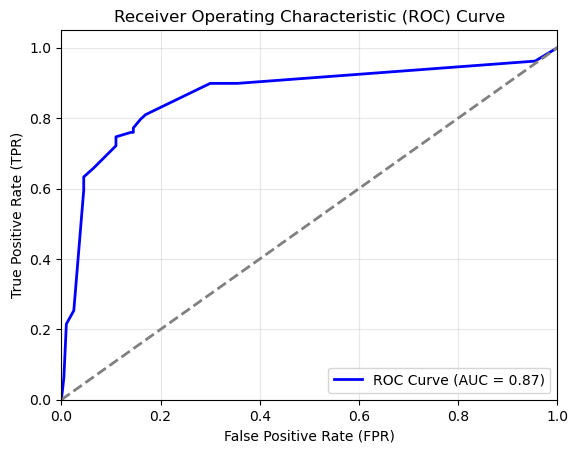

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = skin_cancer_decisiontree.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()